In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


In [2]:
hist = pd.read_csv("data/historical_data.csv")
sent = pd.read_csv("data/fear_greed_index.csv")
hist.head(), sent.head()


(                                      Account  Coin  Execution Price  Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  Closed PnL  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy         0.0   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy         0.0   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy         0.0   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy         0.0   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy         0.0   
 
                                     Transaction Hash   

In [6]:
hist.columns = hist.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("-", "_")
sent.columns = sent.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("-", "_")
hist.columns, sent.columns



(Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee',
        'trade_id', 'timestamp', 'date'],
       dtype='object'),
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object'))

In [7]:
hist["timestamp"] = pd.to_datetime(hist["timestamp"], unit="ms", errors="coerce")
hist["date"] = hist["timestamp"].dt.date
sent["timestamp"] = pd.to_datetime(sent["timestamp"], unit="s", errors="coerce")
sent["date"] = sent["timestamp"].dt.date
hist = hist.dropna(subset=["date"])
sent = sent.dropna(subset=["date"])
hist["date"].min(), hist["date"].max(), sent["date"].min(), sent["date"].max()



(datetime.date(2023, 3, 28),
 datetime.date(2025, 6, 15),
 datetime.date(2018, 2, 1),
 datetime.date(2025, 5, 2))

In [8]:
sent = sent[["date", "classification"]]
merged = hist.merge(sent, on="date", how="inner")
merged.shape


(184263, 18)

In [9]:
merged["win"] = (merged["closed_pnl"] > 0).astype(int)
merged["execution_price"] = pd.to_numeric(merged["execution_price"], errors="coerce")
merged["size_usd"] = pd.to_numeric(merged["size_usd"], errors="coerce")
merged["closed_pnl"] = pd.to_numeric(merged["closed_pnl"], errors="coerce")
daily = merged.groupby(["account","date","classification"]).agg(
    trades_count=("trade_id","count"),
    total_pnl=("closed_pnl","sum"),
    avg_pnl=("closed_pnl","mean"),
    win_rate=("win","mean"),
    total_volume_usd=("size_usd","sum"),
    avg_size_usd=("size_usd","mean")
)
daily.head()


trades_count     total_pnl     avg_pnl  win_rate  total_volume_usd  avg_size_usd
account                                    date       classification                                                                                  
0x083384f897ee0f19899168e3b1bec365f52a9012 2024-10-27 Greed                    462 -3.275059e+05 -708.887230  0.025974        6842632.02  14810.891818
                                           2025-02-19 Fear                    3356  1.927736e+06  574.414696  0.405542       54854631.95  16345.241940
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2024-10-27 Greed                    320  2.060745e+04   64.398269  0.531250         797679.97   2492.749906
                                           2025-02-19 Fear                    3533  1.709873e+04    4.839719  0.435041        5982611.50   1693.351684
0x271b280974205ca63b716753467d5a371de622ab 2024-07-03 Neutral                    5 -1.000000e+00   -0.200000  0.000000          30351.00   6070.200000

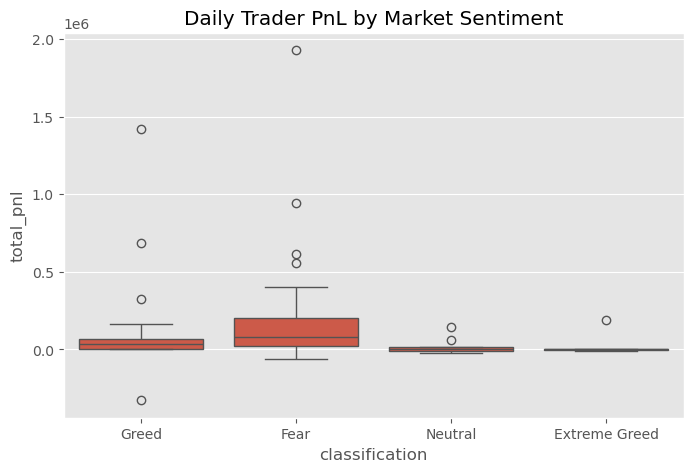

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(data=daily.reset_index(), x="classification", y="total_pnl")
plt.title("Daily Trader PnL by Market Sentiment")
plt.show()


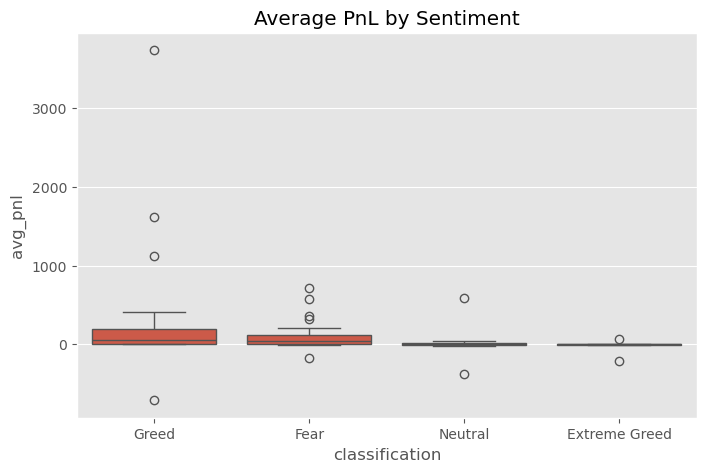

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(data=daily.reset_index(), x="classification", y="avg_pnl")
plt.title("Average PnL by Sentiment")
plt.show()


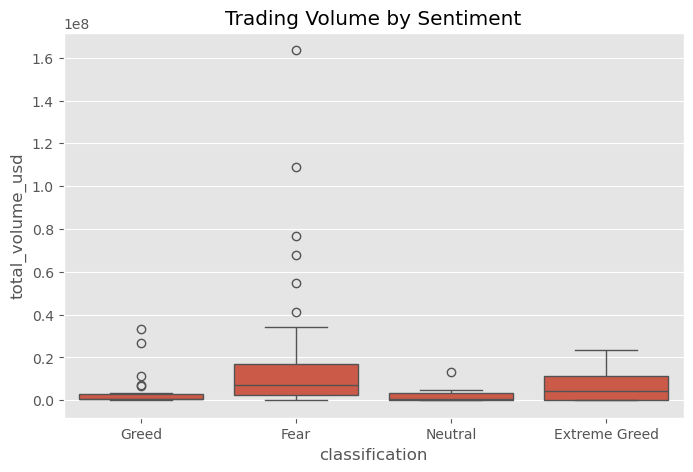

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(data=daily.reset_index(), x="classification", y="total_volume_usd")
plt.title("Trading Volume by Sentiment")
plt.show()


In [13]:
acc_perf = daily.groupby("account").agg(
    days_active=("total_pnl","count"),
    total_pnl=("total_pnl","sum"),
    avg_daily_pnl=("total_pnl","mean"),
    avg_win_rate=("win_rate","mean")
)
acc_perf = acc_perf[acc_perf["days_active"] >= 3]
acc_perf["skill_bucket"] = pd.qcut(acc_perf["avg_daily_pnl"], 3, labels=["Low","Medium","High"])
acc_perf.head()


,days_active,total_pnl,avg_daily_pnl,avg_win_rate,skill_bucket
account,,,,,
0x271b280974205ca63b716753467d5a371de622ab,3,31763.088431,10587.696144,0.410153,Low
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,6,-27704.567439,-4617.427907,0.194149,Low
0x430f09841d65beb3f27765503d0f850b8bce7713,4,416541.872341,104135.468085,0.579597,High
0x4f93fead39b70a1824f981a54d4e55b278e9f760,4,301287.891529,75321.972882,0.339601,Medium
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,4,361576.622700,90394.155675,0.652543,High


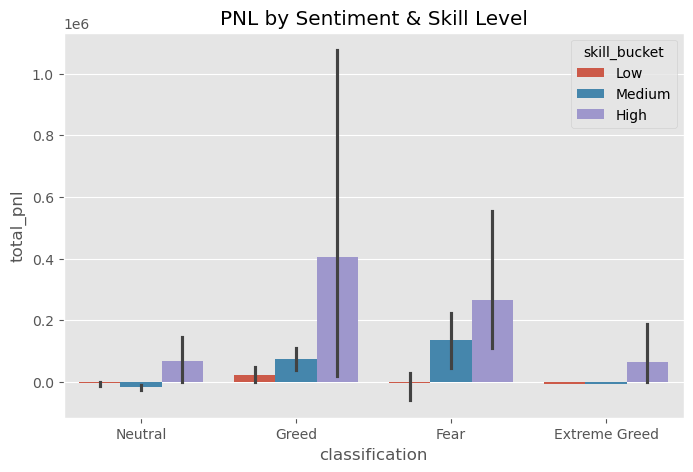

In [14]:
merged2 = daily.reset_index().merge(
    acc_perf[["skill_bucket"]],
    left_on="account",
    right_index=True,
    how="inner"
)
plt.figure(figsize=(8,5))
sns.barplot(data=merged2, x="classification", y="total_pnl", hue="skill_bucket", estimator=np.mean)
plt.title("PNL by Sentiment & Skill Level")
plt.show()


In [15]:
model_data = merged2.copy()
model_data["profitable"] = (model_data["total_pnl"] > 0).astype(int)
model_data["sentiment_is_greed"] = (model_data["classification"].str.lower()=="greed").astype(int)
features = ["sentiment_is_greed","trades_count","total_volume_usd","win_rate"]
X = model_data[features].fillna(0)
y = model_data["profitable"]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.70      1.00      0.82         7

    accuracy                           0.70        10
   macro avg       0.35      0.50      0.41        10
weighted avg       0.49      0.70      0.58        10



C:\Users\ajay1910\Downloads\ProgramTools\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ajay1910\Downloads\ProgramTools\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ajay1910\Downloads\ProgramTools\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr